In [1]:
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from matplotlib import animation
from IPython.display import HTML
import matplotlib
from scipy.interpolate import interp1d
from scipy import interpolate
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
plt.rcParams['font.family'] = "Helvetica"
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

In [3]:
def deal_pbc():
    global xyz_pro, table_pro, traj
    
    chain1_center = np.mean(xyz_pro[:,table_pro.chainID==0,:],axis=1)
    chain2_center = np.mean(xyz_pro[:,table_pro.chainID==1,:],axis=1)
    chain3_center = np.mean(xyz_pro[:,table_pro.chainID==2,:],axis=1)

    for j in range(3):
        pbc_cross_1 = np.where(abs(chain1_center[:,j] - chain2_center[:,j])>4)
        for i in range(len(pbc_cross_1[0])):
            if(chain2_center[pbc_cross_1[0][i],j] - chain1_center[pbc_cross_1[0][i],j] > 0):
                xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] = xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] - traj.unitcell_lengths[pbc_cross_1[0][i],j]
            else:
                xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] = xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] + traj.unitcell_lengths[pbc_cross_1[0][i],j]

        pbc_cross_2 = np.where(abs(chain1_center[:,j] - chain3_center[:,j])>4)
        for i in range(len(pbc_cross_2[0])):
            if(chain3_center[pbc_cross_2[0][i],j] - chain1_center[pbc_cross_2[0][i],j] > 0):
                xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] = xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] - traj.unitcell_lengths[pbc_cross_2[0][i],j]
            else:
                xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] = xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] + traj.unitcell_lengths[pbc_cross_2[0][i],j]
    
    return xyz_pro

    

In [4]:
traj = md.load_xtc('405ns_mol_pro_10.xtc', top = 'pro.gro')
xyz = traj.xyz
top = traj.topology
table, bonds = top.to_dataframe()

In [5]:
xyz_pro = xyz[:,table.element=='C',:]
table_pro = table[table.element=='C']


In [6]:
table_pro

,serial,name,element,resSeq,resName,chainID,segmentID
4,5,CA,C,1,SER,0,
6,7,CB,C,1,SER,0,
11,12,C,C,1,SER,0,
15,16,CA,C,2,PHE,0,
17,18,CB,C,2,PHE,0,
...,...,...,...,...,...,...,...
27027,27028,CB,C,130,ARG,0,
27030,27031,CG,C,130,ARG,0,
27033,27034,CD,C,130,ARG,0,
27038,27039,CZ,C,130,ARG,0,


In [7]:
start_serial = (table_pro[(table_pro.resSeq==1)&(table_pro.name=='CA')].values)[:,0]
end_serial = np.append((start_serial[1:]-1),table_pro.iloc[-1].serial)
for i in range(6):
    table_pro.loc[(start_serial[i]<=table_pro.serial) & (table_pro.serial<=end_serial[i]), 'chainID'] = i+1
for i in range(3):
    table_pro.loc[(start_serial[i]<=table_pro.serial) & (table_pro.serial<=end_serial[i]), 'resSeq'] += 815
for i in range(3):
    table_pro.loc[(start_serial[i+3]<=table_pro.serial) & (table_pro.serial<=end_serial[i+3]), 'resSeq'] += 685

/Users/ruisu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
table_pro

,serial,name,element,resSeq,resName,chainID,segmentID
4,5,CA,C,816,SER,1,
6,7,CB,C,816,SER,1,
11,12,C,C,816,SER,1,
15,16,CA,C,817,PHE,1,
17,18,CB,C,817,PHE,1,
...,...,...,...,...,...,...,...
27027,27028,CB,C,815,ARG,6,
27030,27031,CG,C,815,ARG,6,
27033,27034,CD,C,815,ARG,6,
27038,27039,CZ,C,815,ARG,6,


In [45]:
start_id, end_id = 984, 1033

In [64]:
loc_start = 300
bb_pos = np.zeros((407-loc_start, end_id-start_id+1, 3))

for i in range(start_id, end_id+1)[::-1]:
    bb_pos[:,i-start_id,:] = np.mean(xyz_pro[loc_start:,(table_pro.resSeq==i),:], axis=1)
N_conv = 7
bb_pos_smooth = np.zeros((407-loc_start, end_id-start_id+1-N_conv+1, 3))

for i in range(len(bb_pos)):
    bb_pos_smooth[i,:,0] = np.convolve(bb_pos[i,:,0], np.ones(N_conv)/N_conv, mode='valid')
    bb_pos_smooth[i,:,1] = np.convolve(bb_pos[i,:,1], np.ones(N_conv)/N_conv, mode='valid')
    bb_pos_smooth[i,:,2] = np.convolve(bb_pos[i,:,2], np.ones(N_conv)/N_conv, mode='valid')

(3.4703432151249474, 12.209612539836337, 34.18161697387694, 38.475595419747485)

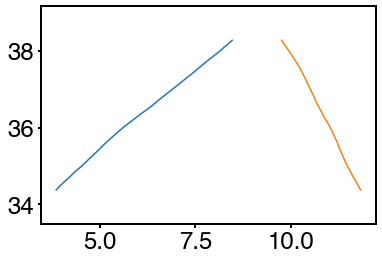

In [65]:
i = 50

plt.plot(bb_pos_smooth[i,:,1],bb_pos_smooth[i,:,2])
#plt.plot(xyz[loc_start+i,:,0], xyz[loc_start+i,:,2], 'go')
plt.plot(bb_pos_smooth[i,:,0],bb_pos_smooth[i,:,2])
plt.axis('equal')

In [66]:
np.shape(bb_pos_smooth)

(107, 44, 3)

In [67]:
bb_arclength = np.zeros((407-loc_start, end_id-start_id+1-N_conv+1))
bb_arclength[:,1:] = np.sqrt(np.sum((bb_pos_smooth[:,1:,:] - bb_pos_smooth[:,:-1,:])**2, axis=2))
bb_arclength = np.cumsum(bb_arclength,axis=1)

In [68]:
bb_orientation = bb_pos_smooth[:,1:,:] - bb_pos_smooth[:,:-1,:]
bb_orientation /= np.linalg.norm(bb_orientation, axis=2)[:,:,np.newaxis]
bb_cos = np.zeros((407-loc_start, end_id-start_id+1-N_conv))
for i in range(len(bb_orientation)):
    bb_cos[i,:] = np.dot(bb_orientation[i,:,:], bb_orientation[i,0,:])

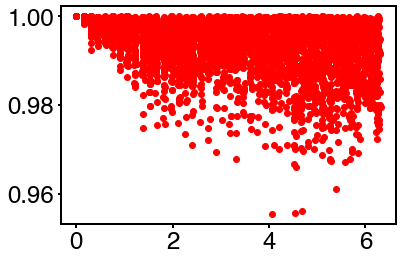

In [69]:
plt.plot(bb_arclength[1:,:-1].ravel(), bb_cos[1:,:].ravel(),'ro')

In [70]:
bins = np.linspace(0,np.max(bb_arclength[1:,:-1]),21)
bin_indices = np.digitize(bb_arclength[1:,:-1].ravel(), bins)
cos_mean = np.zeros(len(bins)-1)
arc_mean = np.zeros(len(bins)-1)
cos_std = np.zeros(len(bins)-1)
arc_std = np.zeros(len(bins)-1)
for i in range(len(cos_mean)):
    arc_mean[i] = np.mean(bb_arclength[1:,:-1].ravel()[bin_indices==i+1])
    arc_std[i] = np.std(bb_arclength[1:,:-1].ravel()[bin_indices==i+1])
    cos_mean[i] = -np.log(np.mean(bb_cos[1:,:].ravel()[bin_indices==i+1]))
    cos_std[i] = np.std(-np.log(bb_cos[1:,:].ravel()[bin_indices==i+1]))

In [71]:
from scipy.optimize import curve_fit
params, confint = curve_fit(lambda t,b: t*b,  arc_mean[:11], cos_mean[:11])
from scipy.stats.distributions import t as student_t
alpha = 0.05 # 95% confidence interval = 100*(1-alpha)
n = len(arc_mean)    # number of data points
p = len(params) # number of parameters
dof = max(0, n - p) # number of degrees of freedom
# student-t value for the dof and confidence level
tval = student_t.ppf(1.0-alpha/2., dof) 
conf95 = -1/2*(1/(-params[0] + np.sqrt((np.diag(confint))[0])*tval) -  1/(-params[0] - np.sqrt((np.diag(confint))[0])*tval))
print('persistence length: %.1f \u00B1 %.1f nm'%(1/params[0], conf95))

persistence length: 399.6 ± 84.7 nm


(0.0, 0.1)

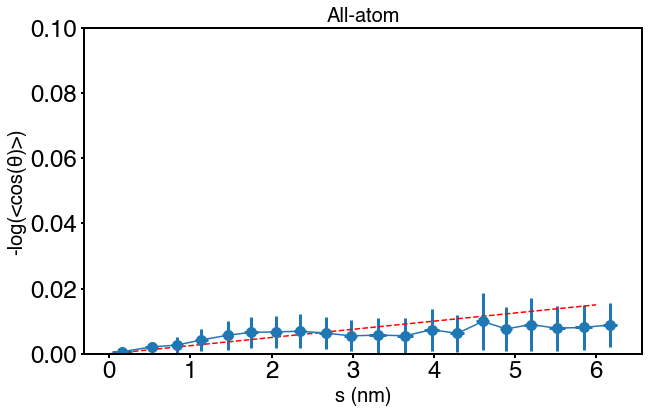

In [72]:
plt.figure(figsize=(10,6))
plt.errorbar(arc_mean, cos_mean, xerr=arc_std, yerr=cos_std, marker='o', elinewidth=3, ms=10)
plt.plot([0,6],np.array([0,6])*params[0],'r--')
plt.xlabel('s (nm)')
plt.ylabel('-log(<cos(\u03B8)>)')
plt.title('All-atom', fontsize=20)
plt.ylim([0,0.1])

In [ ]:
from scipy.optimize import curve_fit
params, confint = curve_fit(lambda t,b: t*b,  arc_mean, cos_mean)
1/params